# Иморты и константы

In [325]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F

SEED = 2021
TEST_SIZE = 0.3
NUM_TARGET_CLASSES = 2

np.random.seed(SEED)

In [389]:
DATA_FILEPATH = '../data/raw/heart.csv'
FILEPATH_TO_SAVE_PROCESSED_DATA = '../data/processed/processed_data.csv'

# Посмотрим на данные

In [21]:
df = pd.read_csv(DATA_FILEPATH)

In [22]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Посмотрим на основне параметры данных

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [24]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [28]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

## Построим матрицу корреляций

In [29]:
corr_mat = df.corr()
top_corr_features = corr_mat.index

<AxesSubplot:>

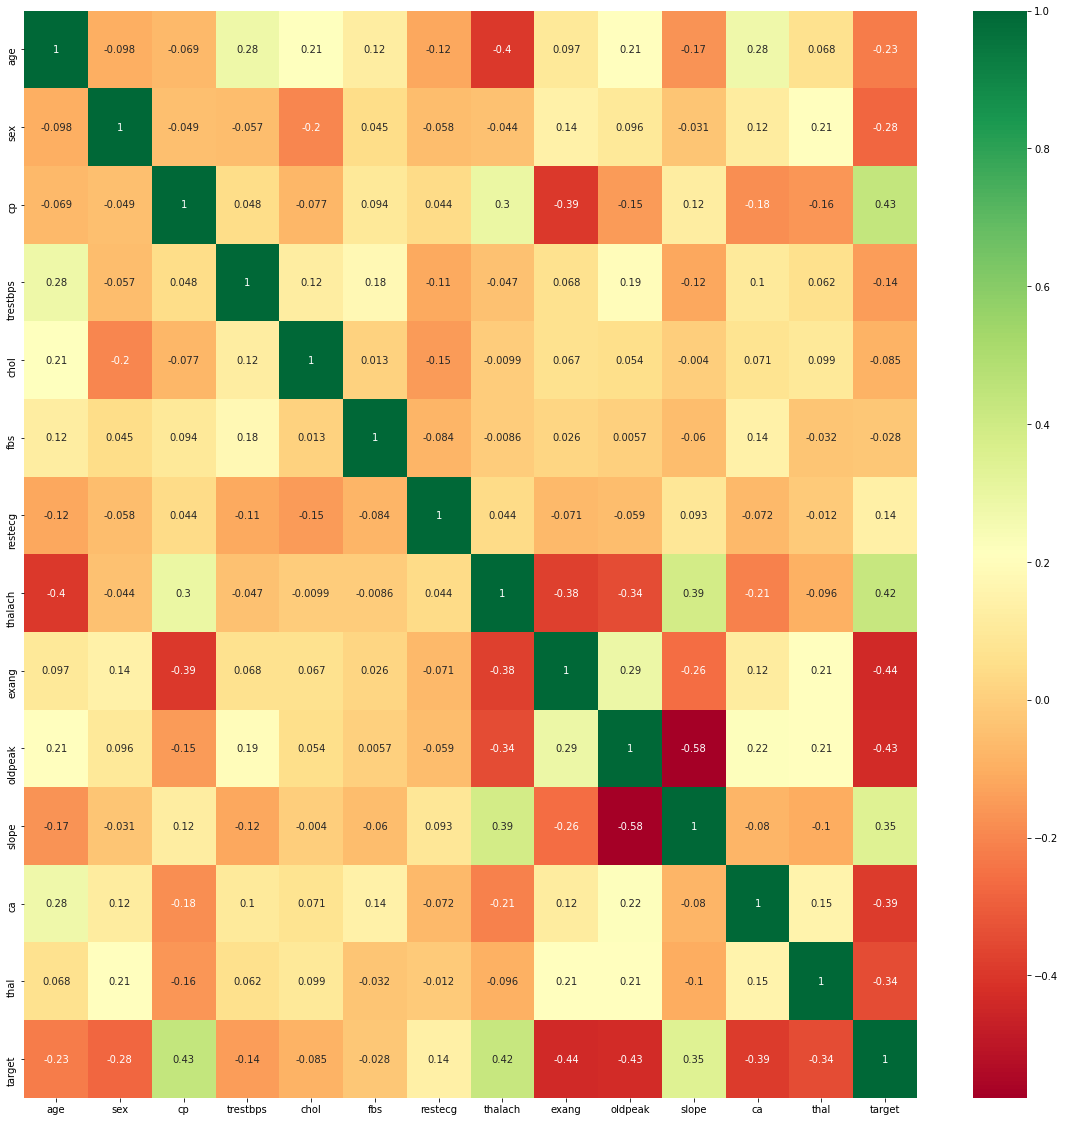

In [31]:
plt.figure(figsize=(20,20))
sns.heatmap(df[top_corr_features].corr(), annot=True, cmap='RdYlGn')

## Посмотрим на соотношение классов 

<AxesSubplot:xlabel='target', ylabel='count'>

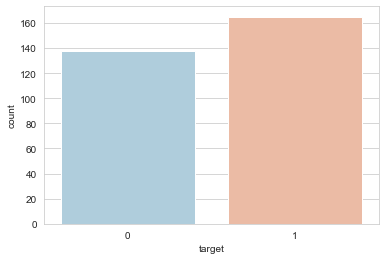

In [33]:
sns.set_style('whitegrid')
sns.countplot(x='target', data=df, palette='RdBu_r')

## Разобьём фичи на числовые и категориальные

In [34]:
numerical_features = ['age','trestbps','chol','thalach','oldpeak']
categorical_features = []
target = 'target'

# Подготовим данные для обучения

In [38]:
# Скопируем датафрейм
prepare_df = df.copy()

## Нормируем числовые фичи

In [36]:
ss = StandardScaler()

In [39]:
prepare_df[numerical_features] = ss.fit_transform(prepare_df[numerical_features])

In [40]:
prepare_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.952197,1,3,0.763956,-0.256334,1,0,0.015443,0,1.087338,0,0,1,1
1,-1.915313,1,2,-0.092738,0.072199,0,1,1.633471,0,2.122573,0,0,2,1
2,-1.474158,0,1,-0.092738,-0.816773,0,0,0.977514,0,0.310912,2,0,2,1
3,0.180175,1,1,-0.663867,-0.198357,0,1,1.239897,0,-0.206705,2,0,2,1
4,0.290464,0,0,-0.663867,2.082050,0,1,0.583939,1,-0.379244,2,0,2,1


## Кодируем категориальные фичи

In [41]:
prepare_df = pd.get_dummies(prepare_df, columns=categorical_features)

In [42]:
prepare_df.head()

,age,trestbps,chol,thalach,oldpeak,target,sex_0,sex_1,cp_0,cp_1,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
0,0.952197,0.763956,-0.256334,0.015443,1.087338,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1,-1.915313,-0.092738,0.072199,1.633471,2.122573,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
2,-1.474158,-0.092738,-0.816773,0.977514,0.310912,1,1,0,0,1,...,1,1,0,0,0,0,0,0,1,0
3,0.180175,-0.663867,-0.198357,1.239897,-0.206705,1,0,1,0,1,...,1,1,0,0,0,0,0,0,1,0
4,0.290464,-0.663867,2.082050,0.583939,-0.379244,1,1,0,1,0,...,1,1,0,0,0,0,0,0,1,0


In [394]:
#Сохраним обработанные данные 
prepare_df.to_csv(FILEPATH_TO_SAVE_PROCESSED_DATA, index=False)

ImportError: cannot import name 'get_filepath_or_buffer' from 'pandas.io.common' (d:\projects\made\ml_in_production\rchermanteev\venv\lib\site-packages\pandas\io\common.py)

## Разобъём на трейн и тест  

In [310]:
X = prepare_df.drop(['target'], axis=1).values
y = prepare_df['target'].values

In [311]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

# Обучим модель

In [321]:
# Определим функцию для подсчёта метрик
def get_metrics(y, y_pred):
    correct = accuracy_score(y, y_pred)
    print(f"Accurcay :   {correct}")
    
    cm = confusion_matrix(y, y_pred)
    total=sum(sum(cm))

    sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
    print('Sensitivity : ', sensitivity )

    specificity = cm[1,1]/(cm[1,1]+cm[0,1])
    print('Specificity : ', specificity)
    
    f1 = f1_score(y, y_pred)
    print(f"f1_score :   {f1}")
    
    roc_auc = roc_auc_score(y, y_pred)
    print(f"roc_auc_score :   {roc_auc}")

## Попробуем LogReg

In [326]:
model = LogisticRegression()

In [327]:
model.fit(X_train, y_train)

LogisticRegression()

In [328]:
y_predict = model.predict(X_test)

In [329]:
get_metrics(y_test, y_predict)

Accurcay :   0.8461538461538461
Sensitivity :  0.8108108108108109
Specificity :  0.8703703703703703
f1_score :   0.8703703703703703
roc_auc_score :   0.8405905905905904


## Попробуем модель RandomForest 

In [312]:
model = RandomForestClassifier(max_depth=5)

In [313]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5)

In [322]:
y_predict = model.predict(X_test)

In [323]:
get_metrics(y_test, y_predict)

Accurcay :   0.8351648351648352
Sensitivity :  0.8055555555555556
Specificity :  0.8545454545454545
f1_score :   0.8623853211009175
roc_auc_score :   0.827077077077077


## Определим модель

In [361]:
class Net(nn.Module):
    def __init__(self, in_count, output_count):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_count, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_count)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return F.relu(x)

## Обучение

In [368]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train) 
y_test = torch.LongTensor(y_test)

In [384]:
model = Net(X.shape[1], NUM_TARGET_CLASSES) 

In [385]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [386]:
final_losses = []
for epochs in range(100):
    optimizer.zero_grad()
    out = model(X_train)
    loss = criterion(out, y_train)
    final_losses.append(loss)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epochs+1}, loss: {loss.item()}")

Epoch 1, loss: 0.6959285140037537
Epoch 2, loss: 0.6941798329353333
Epoch 3, loss: 0.693225085735321
Epoch 4, loss: 0.6928884983062744
Epoch 5, loss: 0.692778468132019
Epoch 6, loss: 0.6926851868629456
Epoch 7, loss: 0.6925684809684753
Epoch 8, loss: 0.6921455264091492
Epoch 9, loss: 0.6912707090377808
Epoch 10, loss: 0.6898393630981445
Epoch 11, loss: 0.6873305439949036
Epoch 12, loss: 0.6841864585876465
Epoch 13, loss: 0.6802960634231567
Epoch 14, loss: 0.6759198904037476
Epoch 15, loss: 0.6712254881858826
Epoch 16, loss: 0.6662737131118774
Epoch 17, loss: 0.6611529588699341
Epoch 18, loss: 0.6559546589851379
Epoch 19, loss: 0.6508401036262512
Epoch 20, loss: 0.6455615758895874
Epoch 21, loss: 0.6402791738510132
Epoch 22, loss: 0.6349583864212036
Epoch 23, loss: 0.6296749711036682
Epoch 24, loss: 0.6244277954101562
Epoch 25, loss: 0.6192352771759033
Epoch 26, loss: 0.6139740943908691
Epoch 27, loss: 0.6086596250534058
Epoch 28, loss: 0.603344202041626
Epoch 29, loss: 0.59773069620132

In [387]:
pred = model(X_test)
_, predict_classes = torch.max(pred, 1)

In [388]:
get_metrics(y_test, predict_classes)

Accurcay :   0.8571428571428571
Sensitivity :  0.8
Specificity :  0.9019607843137255
f1_score :   0.8761904761904761
roc_auc_score :   0.8583583583583584
